# Supervised Music Classifications with CNN 
## 0. Introduction
### 0.1 Task
~ explain task to be solved

### 0.2 Related Work
~ show related work from literature / internet 

## 1. Data Loading and Visualisation

In [61]:
import os
# check current working directory if necessary... 
print(os.getcwd())

/Users/nicolasvogel/Dokumente/16_ZHAW_MSc/V5_6_NeuralNetworks&DeepLearning/NNDL_Project_Repo


### 1. 1 Set random seed

In [62]:
import torch
import numpy as np
import random

# Set seed for PyTorch
torch.manual_seed(42)

# Set seed for NumPy
np.random.seed(42)

# Set seed for Python's random module
random.seed(42)

# If you are using CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # if you are using multi-GPU

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


### 1.2 Load images and safe them in to an image list

In [63]:
import os
from PIL import Image

input_dir = "./images_original/blues"

# load images one after another - useful for images one by one
for image in os.listdir(input_dir):
    img = Image.open(os.path.join(input_dir, image))
    # do whatever you like to do with the img

# load all images data at in to list
image_list = [Image.open(os.path.join(input_dir, image)) for image in os.listdir(input_dir)]


### 1.3 Print first images to get an idea of the data

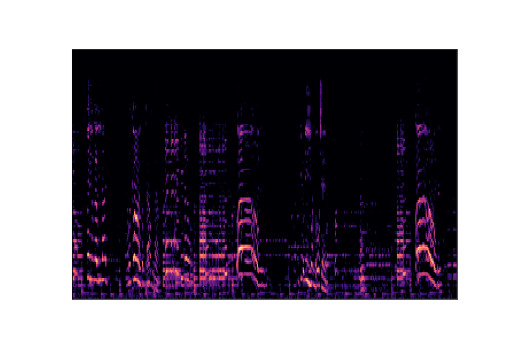

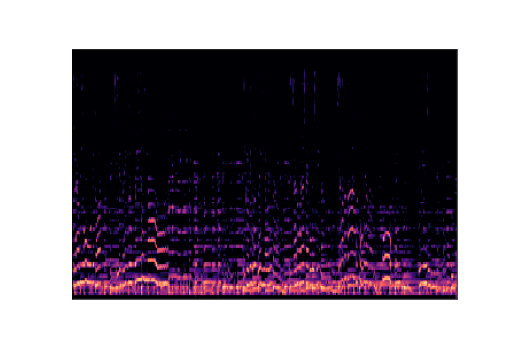

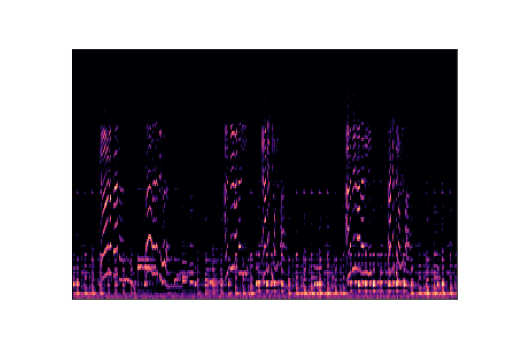

In [64]:
import matplotlib.pyplot as plt

# Print first 3 images in the list
counter = 0
for img in image_list:
    if counter < 3: 
        plt.imshow(img)
        plt.axis('off')  # Hide axes
        plt.show()
        counter += 1
    else: 
        break

### 1.4 Data explanation
~ explain insights from visualizing and analysis

## 2 Data Preprocessing
#### 2.1 Load Data, Subseting 
Load data into tensors and create subset, 

Split the datafolder into test and training data (not equal across genres yet!) -> unbalanced

In [65]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
from torch.utils.data import Subset
import collections

In [66]:
# Data directory
data_dir = "./images_original"
# 
# # Load full the dataset with original image size
# dataset = ImageFolder(data_dir, transform=transforms.Compose([transforms.Resize((288, 432)), # Adjust to original image size 
# transforms.ToTensor()]))
# 
# 
# transform = transforms.Compose([
#     transforms.Resize((288, 432)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # skaliert zu [-1, 1]
# ])
# 
# dataset = ImageFolder(data_dir, transform=transform)

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Schritt 1: Temporärer Transform ohne Normalize
temp_transform = transforms.Compose([
    transforms.Resize((288, 432)),
    transforms.ToTensor()
])

# Schritt 2: Lade Dataset mit dem temporären Transform
temp_dataset = ImageFolder(data_dir, transform=temp_transform)

# Schritt 3: DataLoader daraus erstellen
loader = DataLoader(temp_dataset, batch_size=64, shuffle=False)

# Schritt 4: Mittelwert und Standardabweichung berechnen
mean = 0.
std = 0.
total_images = 0

for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images += batch_samples

mean /= total_images
std /= total_images

print("Dataset Mean:", mean)
print("Dataset Std:", std)

Dataset Mean: tensor([0.4994, 0.4420, 0.5124])
Dataset Std: tensor([0.4564, 0.4717, 0.4318])


In [67]:
transform = transforms.Compose([
    transforms.Resize((288, 432)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dataset = ImageFolder(data_dir, transform=transform)

In [68]:

# # Load the dataset with resized images
# dataset = ImageFolder(data_dir, transform=transforms.Compose([
#     transforms.Resize((150, 150)),
#     transforms.ToTensor()]))

# Load a subset of the dataset*
# criterion for subset, and  initialization
class_counts = collections.defaultdict(int)
max_per_class = 10  # maximum number of spectrograms per genre
genre_indices = []

# Iterate through the dataset and select indices of spectrogram's*
for idx, (img, label) in enumerate(dataset):
    if class_counts[label] < max_per_class:
        genre_indices.append(idx)
        class_counts[label] += 1
    # stopping criteria if all genres contain 10 spectrogram's
    if len(class_counts) == len(dataset.classes) and all(c >= max_per_class for c in class_counts.values()):
        break

# created subset with the selected indices*
Subset = Subset(dataset, genre_indices)

# check length of subset *
print(f"Spectrogram's in subset: {len(Subset)}")

print(dataset)


Spectrogram's in subset: 100
Dataset ImageFolder
    Number of datapoints: 999
    Root location: ./images_original
    StandardTransform
Transform: Compose(
               Resize(size=(288, 432), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=tensor([0.4994, 0.4420, 0.5124]), std=tensor([0.4564, 0.4717, 0.4318]))
           )


### 2.2 Train Test Split
Split the dataset into training and testing sets over whole dataset

In [69]:
# Define the split ratio
# train_ratio = 0.8
# test_ratio = 0.2
# 
# # ==============  Train Test split for whole dataset ============== #
# # Calculate the number of samples for training and testing
# train_size = int(train_ratio * len(dataset))
# test_size = len(dataset) - train_size
# 
# # Randomly split the dataset
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
# 
# # Create data loaders (load the train and validation into batches)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# 
# # Print the number of samples in each set
# print(f"Number of training samples: {len(train_dataset)}") # one sample from the genre jazz is missing --> only 999 instead of 1000 samples
# print(f"Number of testing samples: {len(test_dataset)}")
# print(train_dataset)

Train-test split for the subset is done differently such as the data has to be stratified (equal across genres).

In [70]:
#==============  Train Test split for sub dataset ============== #
# from sklearn.model_selection import train_test_split
# 
# # Collect indices and labels
# all_indices = list(range(len(subset)))
# all_labels = [subset[i][1] for i in all_indices]  # Integer-Labels
# 
# # Stratified Split
# train_indices, test_indices = train_test_split(
#     all_indices,
#     train_size=train_ratio,
#     stratify=all_labels,
#     random_state=42  # for reproducibility
# )
# 
# # create subsets
# train_subset = Subset(subset, train_indices)
# test_subset = Subset(subset, test_indices)
# 
# # Create data loaders (load the train and validation into batches)
# train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)
# 
# # Print the number of samples in each set
# print(f"Number of training samples: {len(train_subset)}") 
# print(f"Number of testing samples: {len(test_subset)}")


Now train-val-test split, stratified so all genres are equaly represented

In [71]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from torch.utils.data import Subset, DataLoader
from collections import Counter
import torch

#  Extracting Tags
targets = [dataset[i][1] for i in range(len(dataset))]  # assuming (x, label)

# Stratified Split: 90% Train+Val, 10% Test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_val_idx, test_idx in sss.split(X=targets, y=targets):
    pass

# # Debug: Testverteilung
# test_targets = [targets[i] for i in test_idx]
# print("Test:", Counter(test_targets))

# Stratified K-Fold on Train+Val (90%)
train_val_targets = [targets[i] for i in train_val_idx]
skf = StratifiedKFold(n_splits=5)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_idx, train_val_targets)):
    # Map indices back to original dataset
    train_indices = [train_val_idx[i] for i in train_idx]
    val_indices = [train_val_idx[i] for i in val_idx]

    train_targets = [targets[i] for i in train_indices]
    val_targets = [targets[i] for i in val_indices]

    # print(f"\nFold {fold+1}")
    # print("Train:", Counter(train_targets))
    # print("Validation:", Counter(val_targets))

    # Erstelle Subsets und Loader
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    test_subset = Subset(dataset, test_idx)

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)


print(f"Number of training samples: {len(train_subset)}") 
print(f"Number of validation samples: {len(val_subset)}")
print(f"Number of test samples: {len(test_subset)}")

Number of training samples: 720
Number of validation samples: 179
Number of test samples: 100


check if train-test split is stratified (equal across genres)

In [72]:
from collections import Counter

# helper function to get distribution of classes
def get_dist(ds):
    return Counter([ds[i][1] for i in range(len(ds))])

# print distributions
print("Train:", get_dist(train_subset))
print("Validation:", get_dist(val_subset))
print("Test:", get_dist(test_subset))

# print distributions
# print("Train:", get_dist(train_subset))
# print("Test:", get_dist(test_subset))

Train: Counter({6: 72, 8: 72, 0: 72, 3: 72, 4: 72, 5: 72, 7: 72, 1: 72, 2: 72, 9: 72})
Validation: Counter({6: 18, 8: 18, 2: 18, 3: 18, 0: 18, 7: 18, 4: 18, 1: 18, 9: 18, 5: 17})
Test: Counter({3: 10, 4: 10, 1: 10, 0: 10, 9: 10, 7: 10, 2: 10, 8: 10, 5: 10, 6: 10})


### 2.3 Visualize some samples
Look at first 3 images of training dataset (function proposed by microsoft copilot)


In [73]:
# Function to show an image
# def show_image(img, title=None):
#     img = img.permute(1, 2, 0)  # Change the order of dimensions
#     plt.imshow(img)
#     if title:
#         plt.title(title)
#     plt.axis('off')
#     plt.show()
# 
# # print indices of the genres
# print("Genre : indices mapping:", dataset.class_to_idx)
# 
# # Display a few images from the training dataset
# for i in range(3):  # Change the range to display more or fewer images
#     img, label = train_subset[i]
#     show_image(img, title=f"Label: {train_subset.dataset.indices[label]}")
    

#### Visualize training batch (batch size 32 see above)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1866194..1.1829625].


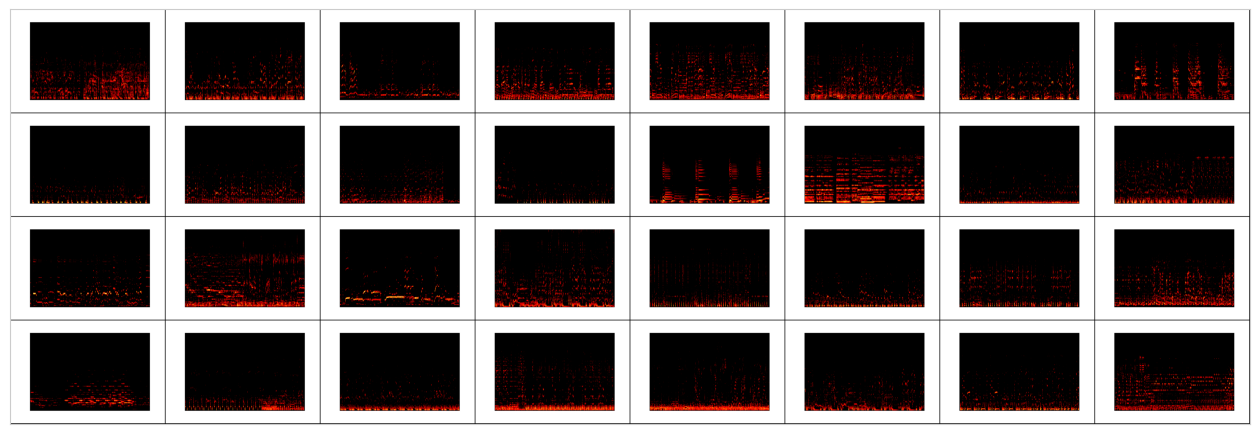

In [74]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=8).permute(1,2,0))
        break

show_batch(train_loader)

### 2.4 Recall tensor shapes of dataset and subset

In [75]:
img, label = dataset[0]
print("Tensor shape (dataset):",  img.shape, "Genre:", label)
img, label = train_subset[0]
print("Tensor shape (subset):", img.shape, "Genre:", label) # prints size of first image: 3 channels (RGB), height, width
# show_image(img, title=f"Label: {train_subset.dataset.indices[label]}")

#output :
#torch.Size([3, 288, 432])  
#torch.Size([3, 288, 432])

Tensor shape (dataset): torch.Size([3, 288, 432]) Genre: 0
Tensor shape (subset): torch.Size([3, 288, 432]) Genre: 6


## 3 Model Development
### 3.1 Base Model for Image Classification
This base class is used to develop all neural networks. We add functionalities to the base to train the model, 

validate the model and get the result for each epoch. It's reusable and can be used for any image classification model, 

no need to rewrite this every time.

In [76]:
import torch.nn as nn
import torch.nn.functional as F
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# def accuracy(outputs, labels):
   # _, preds = torch.max(outputs, dim=1)
    # return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)).to(labels.device)
    
    
    
class ImageClassificationBase(nn.Module):
    
        
    def training_step(self, batch):
        inputs, labels = batch
        # inputs = inputs.to(self.device)  
        # labels = labels.to(self.device)
        out = self(inputs)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'train_loss': loss, 'train_acc': acc}


    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)         # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}


    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    # def epoch_end(self, epoch, result):
    #     print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'],result['val_loss'], result['val_acc']))
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, time: {:.2f}s".format(epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc'], result['epoch_time']))



Concepts to refine the model: Convolution, Padding, Stride, Maxpooling

### 3.2 CNN Model Architecture 
Final model with 3 CNN blocks, each consisting of 2 convolutional layers & 1 max-pooling layer. 

Relu activation function is used to remove negative values from the feature map. 

Stride(1, 1), padding = 1. After applying convolution and feature extracting a flatten layer is used to flatten the tensor from 3 to 1 dimension. 

Then 3 linear layers are added to reduce the size of the tensor and learn the features.

In [77]:

class CNN_dynamic(ImageClassificationBase):
    def __init__(self, conv_configs, linear_sizes):
        """
        conv_configs: list of tuples -> [(out_channels, kernel_size, padding), ...]
        linear_sizes: list with numbers of neurons for each fc layer -> [input_size, hidden1, hidden2, ..., output_size]
        """
        super().__init__()
        self.device = device or torch.device("cpu")
        self.conv_layers = nn.ModuleList() # initializing a list for the convolutional blocks
        input_channels = 3 # the input pictures have only three channels
        for output_channels, kernel_size, padding, use_pool in conv_configs:
            self.conv_layers.append(nn.Conv2d(input_channels, output_channels, kernel_size, padding = padding))
            self.conv_layers.append(nn.ReLU())
            if use_pool: # functionality to avoid pooling at the end of a layer
                self.conv_layers.append(nn.MaxPool2d(2, 2))
            input_channels = output_channels # reassign the input channel to the output channels of the previous layer
            
        self.flatten = nn.Flatten()
        
        self.linear_layers = nn.ModuleList() # initializing a list for the linear fully connected layers
        for i in range(len(linear_sizes) -1):
            self.linear_layers.append(nn.Linear(linear_sizes[i], linear_sizes[i+1]))
            if i < len(linear_sizes) - 2:
                self.linear_layers.append(nn.ReLU())
            
        # self.linear_layers.append(nn.Softmax(dim = 1))
    
    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        x = self.flatten(x)
        for layer in self.linear_layers:
            x = layer(x)
        return x
                

### 3.3 Training Loop

In [78]:
import time

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
 
 
def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        start_time = time.time()

        model.train()
        train_losses = []
        train_accs = []

        for batch in train_loader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Get both loss and accuracy
            result = model.training_step((inputs, labels))
            train_losses.append(result['train_loss'])
            train_accs.append(result['train_acc'])

            # Backprop using just the loss
            result['train_loss'].backward()
            optimizer.step()
            optimizer.zero_grad()

        # Evaluate on validation set
        result = evaluate(model, val_loader)

        # Add average training metrics
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()
        result['epoch_time'] = time.time() - start_time

        # Print metrics
        model.epoch_end(epoch, result)

        history.append(result)

    return history

### 3.4 Model Training
Now we have to train the music genre classification model on the training dataset. That defines the fit, evaluation and accuracy methods.

In [79]:
# Instantiate the model
# initialize conv layers
conv_configs = [(4, 3, 'same', False), (4, 3, 'same', True), 
                            (8, 3, 'same', False), (8, 3, 'same', True), 
                            (16, 3, 'same', False), (16, 3, 'same', True),
                            (32, 3, 'same', True), (32, 3, 'same', True)]
                            # (128, 3, 'same', False), (128, 3, 'same', True), (128, 3, 'same', False), (128, 3, 'same', True)]
                            # (254, 3, 'same', False), (254, 3, 'same', True), (254, 3, 'same', False), (254, 3, 'same', True)]
linear_sizes = [3744, 1024, 128, 10]


conv_configs_VGG = [(64, 3, 'same', False), (64, 3, 'same', True), 
                                     (128, 3, 'same', False), (128, 3, 'same', True), 
                                     (256, 3, 'same', False), (256, 3, 'same', False), (256, 3, 'same', False), (256, 3, 'same', True), 
                                     (512, 3, 'same', False), (512, 3, 'same', False), (512, 3, 'same', False),  (512, 3, 'same', True), 
                                     (512, 3, 'same', False), (512, 3, 'same', False), (512, 3, 'same', False),  (512, 3, 'same', True)]

linear_sizes_VGG = [4096, 1024, 128, 10]

torch.manual_seed(42)
model = CNN_dynamic(conv_configs, linear_sizes).to(device)


for name, param in model.named_parameters(): # to check if the weights change, if not weights are loaded or seed is active (inhibits training)
   print("Name:", name, "Param Data:\n", param.data)
   

Name: conv_layers.0.weight Param Data:
 tensor([[[[ 0.1471,  0.1597, -0.0451],
          [ 0.1768, -0.0422,  0.0388],
          [-0.0937,  0.1130,  0.1697]],

         [[-0.1412,  0.1673,  0.0360],
          [ 0.1422,  0.0261,  0.0928],
          [-0.0272,  0.1484,  0.0284]],

         [[-0.0898,  0.0491, -0.0887],
          [-0.0226, -0.0782,  0.1277],
          [-0.1519, -0.0887, -0.0543]]],


        [[[-0.1157,  0.0182, -0.1901],
          [ 0.1738, -0.1635,  0.1486],
          [ 0.0320, -0.0625,  0.1189]],

         [[ 0.0300,  0.1555,  0.0210],
          [-0.0607,  0.0517, -0.0522],
          [ 0.0810,  0.1718,  0.1112]],

         [[-0.0841,  0.1111,  0.0344],
          [ 0.0977, -0.1173, -0.1905],
          [-0.0744, -0.1476,  0.1579]]],


        [[[ 0.0554,  0.0797,  0.0609],
          [-0.0033,  0.1506, -0.1367],
          [ 0.0121, -0.1314,  0.0593]],

         [[-0.0663,  0.0590, -0.0401],
          [ 0.1596, -0.1141, -0.1148],
          [-0.1148,  0.1731,  0.0641]],

    

In [80]:
# Number of epochs
num_epochs = 100

# Optimizer
opt_func = torch.optim.Adam

# Learning rate
lr = 0.001

# fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func) # in online article they used val_loader (validation) instead of test_loader


Epoch [0], train_loss: 2.3057, train_acc: 0.1005, val_loss: 2.3028, val_acc: 0.1009, time: 32.11s
Epoch [1], train_loss: 2.3040, train_acc: 0.0978, val_loss: 2.3027, val_acc: 0.1009, time: 30.74s
Epoch [2], train_loss: 2.3036, train_acc: 0.0992, val_loss: 2.3026, val_acc: 0.1009, time: 31.37s
Epoch [3], train_loss: 2.3032, train_acc: 0.0978, val_loss: 2.3024, val_acc: 0.1009, time: 34.82s
Epoch [4], train_loss: 2.3029, train_acc: 0.1019, val_loss: 2.3023, val_acc: 0.1009, time: 33.71s
Epoch [5], train_loss: 2.3033, train_acc: 0.0924, val_loss: 2.3024, val_acc: 0.1009, time: 34.82s
Epoch [6], train_loss: 2.3033, train_acc: 0.0992, val_loss: 2.3025, val_acc: 0.1009, time: 34.09s
Epoch [7], train_loss: 2.3033, train_acc: 0.0965, val_loss: 2.3026, val_acc: 0.1009, time: 34.36s


KeyboardInterrupt: 

In [ ]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"{name} grad max: {param.grad.max()}, grad min: {param.grad.min()}")
    else:
        print('...')

# # Check the number of classes in the dataset
# num_classes = len(dataset.classes)
# print(f"Number of classes: {num_classes}")
# 
# for hist in history: 
#     print(hist['train_loss'])
#     
# plt.plot([h['val_loss'] for h in history], label='Validation Loss')
# # plt.plot([h['val_acc'] for h in history], label='Validation Accuracy')
# plt.plot([h['train_loss'] for h in history], label='Train Loss')
# plt.legend()
# plt.show()

### 3.5 Model Evaluation: Ploting the Results

In [20]:
from datetime import date
num_Conv_layers = len(conv_configs)
num_linear_layers = len(linear_sizes)

def plot_accuracies(history):
    """ Plot the history of accuracies"""
    val_accuracies = [x['val_acc'] for x in history]
    train_accuracies = [x['train_acc'] for x in history]
    plt.plot(val_accuracies, '-rx')
    plt.plot(train_accuracies, '-bx')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    filename_acc = f"{date.today()}_Accuracy_conv{num_Conv_layers}_ep{num_epochs}_max{max_per_class}.png"
    plt.savefig(filename_acc, dpi=600)
    

plot_accuracies(history)

NameError: name 'history' is not defined

In [ ]:

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    filename_loss = f"{date.today()}_Loss_conv{num_Conv_layers}_ep{num_epochs}_max{max_per_class}.png"
    plt.savefig(filename_loss, dpi=600)

plot_losses(history)

### 3.6 Saving Model Summary

In [ ]:
print(opt_func)

In [ ]:
def save_model_summary(model, filepath="model_summary.txt", epochs=None, lr=None, optimizer=None, batch_size=None, device=None, max_per_class = None, epoch_times = None):
    with open(filepath, "w") as f:
        f.write("Model Architecture:\n")
        f.write(str(model))
        f.write("\n\n--- Hyperparameters ---\n")
        if epochs is not None:
            f.write(f"Epochs: {epochs}\n")
        if lr is not None:
            f.write(f"Learning Rate: {lr}\n")
        if optimizer is not None:
            f.write(f"Optimizer: {optimizer.__class__.__name__}\n")
        if batch_size is not None:
            f.write(f"Batch Size: {batch_size}\n")
        if device is not None:
            f.write(f"Device: {device}\n")
        if max_per_class is not None:
            f.write(f"Subset size: {max_per_class}\n")
            
        if epoch_times is not None:
            total_time = sum(epoch_times)
            f.write(f"\n--- Runtime ---\n")
            f.write(f"Total training time: {total_time:.2f} seconds\n")    
            f.write(f"Mean training time: {total_time/num_epochs:.2f} seconds/epoch\n")
            
        
        f.write("\n--- Parameters ---\n")
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        f.write(f"Total parameters: {total_params}\n")
        f.write(f"Trainable parameters: {trainable_params}\n")
        
    
filename_model_summary = f"{date.today()}_Model-Summary_conv{num_Conv_layers}_ep{num_epochs}_max{max_per_class}.txt"
epoch_times = [entry['epoch_time'] for entry in history]
optimizer = opt_func

save_model_summary(model,
                   filepath=filename_model_summary, 
                   epochs=num_epochs,
                   lr=lr,
                   optimizer=optimizer,
                   batch_size=32,
                   device=device,
                   max_per_class = None, 
                   epoch_times = epoch_times)

## 4. Model Evaluation
### 4.1 Classification Report

In [ ]:
# imports
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd

# Function to save y_pred and y_true

def save_predictions(model, test_loader):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

# initialize lists for true and predicted labels
y_true = []
y_pred = []

# save predictions
save_predictions(model, test_loader)

# extract labels from dataset
label_idx = [dataset.class_to_idx[i] for i in dataset.classes] # extracting the labels from the dataset-class dict

# initialize classification report
clf_report = classification_report(y_true, y_pred, labels=label_idx, target_names=dataset.classes, output_dict=True)

# Plot seaborn heatmap of classification report
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.title('Classification Report')
filename_clf = f"{date.today()}_Clf-Report_conv{num_Conv_layers}_ep{num_epochs}_max{max_per_class}.png"
plt.savefig(filename_clf, dpi=600)

print(clf_report)

### 4.1 Confusion Matrix

In [ ]:
# imports
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=dataset.classes)
disp.plot(); 
plt.title('Confusion Matrix (Test set)')
plt.grid(None)
filename_cmat = f"{date.today()}_Conf-Mat_conv{num_Conv_layers}_ep{num_epochs}_max{max_per_class}.png"
plt.savefig(filename_cmat, dpi=600)

print(len(y_true))


## 5. Hyperparamter Tuning and Regularization


In [ ]:
# Module import

# Parameter Grid
learning_rates = []
batch_sizes = []
